In [ ]:
# CNN (10 layers)

In [1]:
import os
%matplotlib inline
from theano import *
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers, updates
from nolearn.lasagne import NeuralNet
import pylab
import matplotlib.pyplot as plt
import cPickle as pickle

FTRAIN =  '../data/misc/face_data/training.csv'
FTEST = '../data/misc/face_data/test.csv'
model_root= '/home/faizy/workspace/.project/right_whale/models'

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GT 740M (CNMeM is disabled)


In [2]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y






In [3]:
def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [ ]:
X, y = load2d()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

In [4]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(3, 3),
    conv2_num_filters=64, conv2_filter_size=(5, 5), pool2_pool_size=(3, 3),
    conv3_num_filters=64, conv3_filter_size=(5, 5), pool3_pool_size=(3, 3),
    output_num_units=30, output_nonlinearity=None,

    update=updates.adam,

    regression=True,
    max_epochs=10,
    verbose=1,
)

In [ ]:
X, y = load2d()
net1.fit(X, y);

In [ ]:
with open(os.path.join(model_root, 'net2.pickle'), 'wb') as f:
    pickle.dump(net1, f, -1)
f.close()


In [5]:
with open(model_root+'/net1.pickle', 'rb') as f:
    net = pickle.load(f)

f.close()

/home/faizy/src/lasagne/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


ImageId    1783
Image      1783
dtype: int64


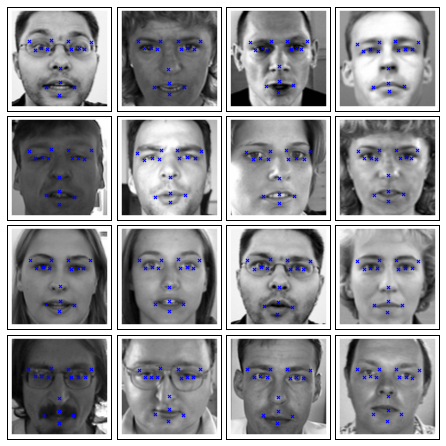

In [6]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load2d(test=True)
y_pred = net.predict(X)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()